In [32]:
# import matplotlib.pyplot as plt
# import sys
# sys.path.append("../PycastWorld")
# sys.path.append("../Gym")
# from gym_pycastworld.PycastWorldEnv import PycastWorldEnv

# sys.path.append("../Automator")
# from AutoGen import Navigator

from fastai.vision.all import *
from fastbook import *
import datetime;
from fastai.vision.widgets import *

# import sys
# import fastprogress
# from matplotlib.animation import FuncAnimation

# from IPython.display import HTML
# sys.path.append("../PycastWorld")
# from gym_pycastworld.PycastWorldEnv import PycastWorldEnv  # type: ignore

In [7]:
path = Path('/raid/Images/40_mazes_05-06-2021_23-27')

In [37]:
name = "blah"
os.system(f"mkdir {name}-diagnostics")
save_path = os.path.abspath(f"{name}-diagnostics")

In [38]:
plt.figure(figsize=(15, 10)) 
plt.savefig(os.path.join(save_path, f"completionchart_test.png"))

<Figure size 1080x720 with 0 Axes>

In [3]:
ns = !ls -l '/raid/Images/40_mazes_05-06-2021_23-27/straight' | wc -l
ns = int(ns[0])

In [5]:
ns

55924

In [4]:
nl = !ls -l '/raid/Images/40_mazes_05-06-2021_23-27/left' | wc -l
nl = int(nl[0])

In [15]:
nl

16174

In [5]:
nr = !ls -l '/raid/Images/40_mazes_05-06-2021_23-27/right' | wc -l
nr = int(nr[0])

In [17]:
nr

16051

# Make Proxy Dataset

In [9]:
# calculate propotions
total = ns + nl + nr
# proportion of lefts images: 
left_proportion = nl/total
# proportion of right images:
right_proportion = nr/total

    lefts = (path/'left').ls().sorted()
    rights = (path/'right').ls().sorted()
    straights = (path/'straight').ls().sorted()

# Left subset size 
left_subset_len = int(5000*left_proportion)
# Right subset size
right_subset_len = int(5000*right_proportion)
# Straight subsetsize
straight_subset_len = 5000 - (910 + 917)

lefts = np.random.choice(lefts, left_subset_len)
rights = np.random.choice(rights, right_subset_len)
straights = np.random.choice(straights, straight_subset_len)

In [71]:
!ls -l '/raid/Images/proxydata/right' | wc -l

851


In [72]:
!ls -l '/raid/Images/proxydata/straight' | wc -l

3060


In [73]:
!ls -l '/raid/Images/proxydata/left' | wc -l

843


In [3]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)

In [4]:
torch.cuda.current_device()

1

In [42]:
path = Path('/raid/Images/proxydata/')

In [3]:
dls = ImageDataLoaders.from_folder(path, valid_pct=0.2, seed=42, item_tfms=Resize(224)) 

In [4]:
dls.n

3885

In [16]:
n_straight = 0
n_left = 0
n_right = 0
for p in dls.items:
    if "straight" in str(p):
        n_straight += 1
    if "left" in str(p):
        n_left += 1
    if "right" in str(p):
        n_right += 1
n_left, n_right, n_straight

(705, 691, 2489)

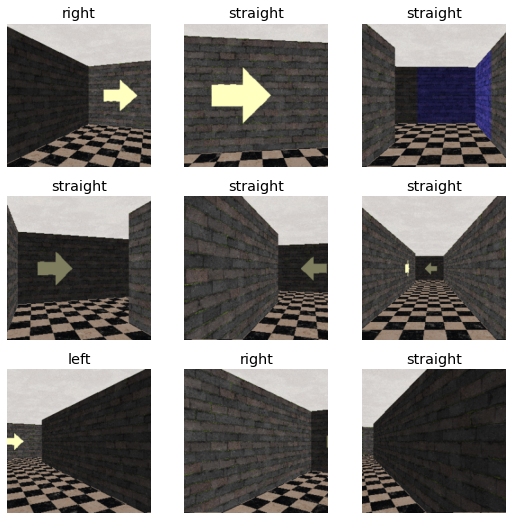

In [5]:
dls.show_batch()

### Try Learning without Weights

In [6]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(5, cbs=SaveModelCallback())

epoch,train_loss,valid_loss,error_rate,time
0,1.111941,0.669601,0.201854,00:10


Better model found at epoch 0 with valid_loss value: 0.6696009635925293.


epoch,train_loss,valid_loss,error_rate,time
0,0.621096,0.474446,0.130793,00:12
1,0.556455,0.401963,0.115345,00:12
2,0.437023,0.375454,0.121524,00:12
3,0.351613,0.351958,0.106076,00:12
4,0.290263,0.350314,0.109166,00:12


Better model found at epoch 0 with valid_loss value: 0.47444629669189453.
Better model found at epoch 1 with valid_loss value: 0.4019629657268524.
Better model found at epoch 2 with valid_loss value: 0.37545403838157654.
Better model found at epoch 3 with valid_loss value: 0.35195812582969666.
Better model found at epoch 4 with valid_loss value: 0.3503141701221466.


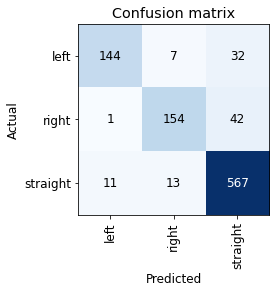

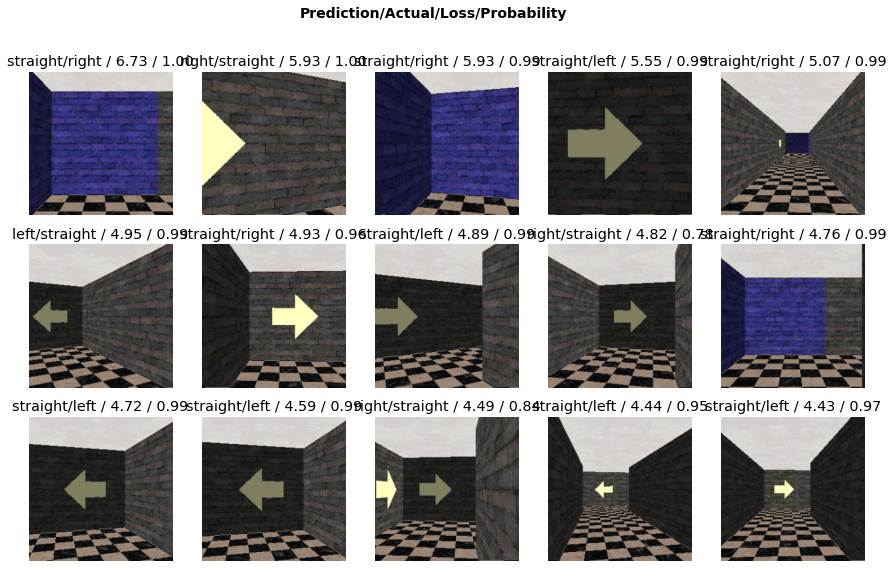

In [7]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(15)

### With Weights

In [ ]:
cuda = torch.device("cuda")
n_samples = 889 + 3081 + 889
weights = n_samples / (3 * np.array([889, 889, 3081]))
# weights = torch.tensor([n_left, n_right, n_straight], device=cuda)
weights = torch.tensor(weights, device=cuda)
weights = weights.type(torch.float)
weights

In [42]:
learn2 = cnn_learner(dls, resnet34, metrics=error_rate, loss_func = CrossEntropyLossFlat(weight = weights))
learn2.fine_tune(5, cbs=SaveModelCallback())

epoch,train_loss,valid_loss,error_rate,time
0,1.156164,0.728783,0.258496,00:10


Better model found at epoch 0 with valid_loss value: 0.7287828922271729.


epoch,train_loss,valid_loss,error_rate,time
0,0.738730,0.544323,0.213182,00:13
1,0.652983,0.548460,0.201854,00:13
2,0.543807,0.444945,0.158599,00:13
3,0.426395,0.412050,0.135942,00:13
4,0.340398,0.409137,0.136972,00:13


Better model found at epoch 0 with valid_loss value: 0.544322669506073.
Better model found at epoch 2 with valid_loss value: 0.44494515657424927.
Better model found at epoch 3 with valid_loss value: 0.41204991936683655.
Better model found at epoch 4 with valid_loss value: 0.40913674235343933.


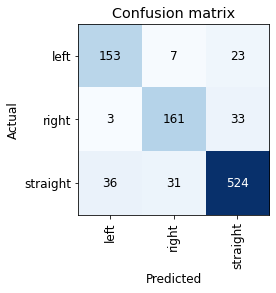

In [53]:
interp2 = ClassificationInterpretation.from_learner(learn2)
interp2.plot_confusion_matrix()

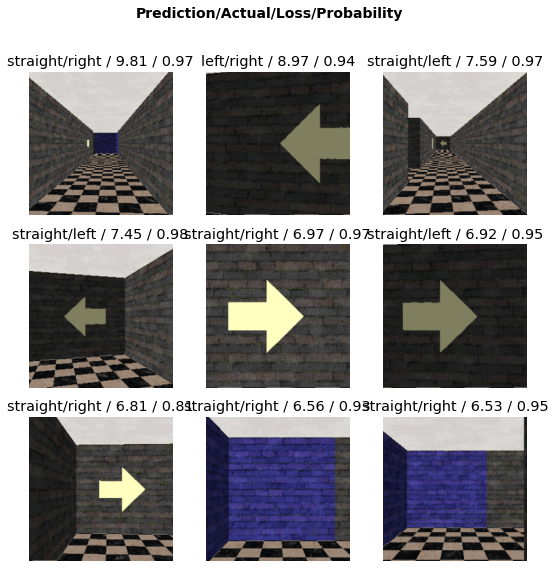

In [60]:
interp2.plot_top_losses(9)

In [47]:
interp2.print_classification_report()

              precision    recall  f1-score   support

        left       0.80      0.84      0.82       183
       right       0.81      0.82      0.81       197
    straight       0.90      0.89      0.89       591

    accuracy                           0.86       971
   macro avg       0.84      0.85      0.84       971
weighted avg       0.86      0.86      0.86       971



In [51]:
interp2.most_confused()

[('straight', 'left', 36),
 ('right', 'straight', 33),
 ('straight', 'right', 31),
 ('left', 'straight', 23),
 ('left', 'right', 7),
 ('right', 'left', 3)]

# Data Cleaning

### Before: Copy Directory in Terminal

### First Clean for Non-Weight Learner

In [13]:
rm_files = []
for indx in interp.top_losses(20).indices:
    print(dls.valid_ds.items[indx.item()])

/raid/Images/proxydata/right/06288.png
/raid/Images/proxydata/straight/41689.png
/raid/Images/proxydata/right/06283.png
/raid/Images/proxydata/left/03854.png
/raid/Images/proxydata/right/13542.png
/raid/Images/proxydata/straight/21927.png
/raid/Images/proxydata/right/14980.png
/raid/Images/proxydata/left/05759.png
/raid/Images/proxydata/straight/16920.png
/raid/Images/proxydata/right/11302.png
/raid/Images/proxydata/left/02433.png
/raid/Images/proxydata/left/00699.png
/raid/Images/proxydata/straight/42685.png
/raid/Images/proxydata/left/13471.png
/raid/Images/proxydata/left/15459.png
/raid/Images/proxydata/left/14820.png
/raid/Images/proxydata/left/06585.png
/raid/Images/proxydata/right/10247.png
/raid/Images/proxydata/left/11312.png
/raid/Images/proxydata/right/12234.png


In [24]:
path = Path('/raid/Images/proxy_clean')

In [28]:
import os
os.path.abspath("/raid/Images/proxy_clean")

'/raid/Images/proxy_clean'

In [30]:
os.system('mkdir test')

256

In [23]:
path = Path('/raid/Images')

In [10]:
for v in interp.top_losses(20).values:
    print(v)

tensor(6.7308)
tensor(5.9284)
tensor(5.9255)
tensor(5.5467)
tensor(5.0677)
tensor(4.9533)
tensor(4.9260)
tensor(4.8897)
tensor(4.8165)
tensor(4.7605)
tensor(4.7217)
tensor(4.5943)
tensor(4.4892)
tensor(4.4363)
tensor(4.4312)
tensor(4.3750)
tensor(4.3483)
tensor(4.2421)
tensor(4.1912)
tensor(4.1070)


In [58]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [65]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [66]:
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [67]:
dls = ImageDataLoaders.from_folder(path, valid_pct=0.2, seed=42, item_tfms=Resize(224)) 

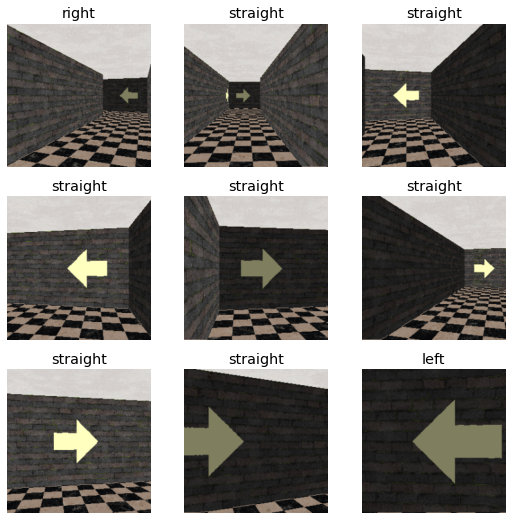

In [68]:
dls.show_batch()

In [69]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(5, cbs=SaveModelCallback())

epoch,train_loss,valid_loss,error_rate,time
0,1.049827,0.482704,0.125263,00:10


Better model found at epoch 0 with valid_loss value: 0.482704222202301.


epoch,train_loss,valid_loss,error_rate,time
0,0.564838,0.418245,0.114737,00:12
1,0.438772,0.375444,0.100000,00:13
2,0.360501,0.241294,0.081053,00:12
3,0.274642,0.231586,0.071579,00:12
4,0.212445,0.235527,0.070526,00:13


Better model found at epoch 0 with valid_loss value: 0.41824477910995483.
Better model found at epoch 1 with valid_loss value: 0.3754444122314453.
Better model found at epoch 2 with valid_loss value: 0.24129417538642883.
Better model found at epoch 3 with valid_loss value: 0.2315863072872162.


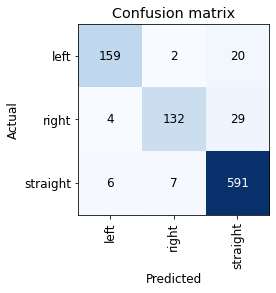

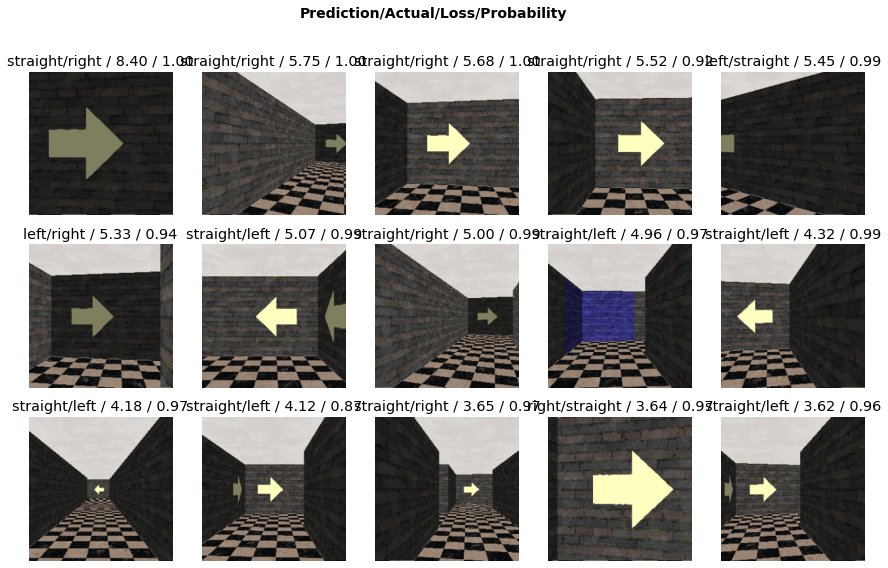

In [70]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(15)

In [82]:
num_s = !ls -l '/raid/Images/proxydata/straight' | wc -l
num_l = !ls -l '/raid/Images/proxydata/left' | wc -l
num_r = !ls -l '/raid/Images/proxydata/right' | wc -l

num_s = int(num_s[0])
num_l = int(num_l[0])
num_r = int(num_r[0])

num_s, num_l, num_r

(3060, 843, 851)

In [83]:
cuda = torch.device("cuda")
n_samples = num_s + num_l + num_r
weights = n_samples / (3 * np.array([num_l, num_r, num_s]))
# weights = torch.tensor([n_left, n_right, n_straight], device=cuda)
weights = torch.tensor(weights, device=cuda)
weights = weights.type(torch.float)
weights

tensor([1.8798, 1.8621, 0.5179], device='cuda:0')

In [84]:
learn2 = cnn_learner(dls, resnet34, metrics=error_rate, loss_func = CrossEntropyLossFlat(weight = weights))
learn2.fine_tune(5, cbs=SaveModelCallback())

epoch,train_loss,valid_loss,error_rate,time
0,1.107227,0.672960,0.227368,00:10


Better model found at epoch 0 with valid_loss value: 0.6729601621627808.


epoch,train_loss,valid_loss,error_rate,time
0,0.638718,0.417497,0.172632,00:12
1,0.538725,0.380036,0.107368,00:12
2,0.419077,0.363983,0.116842,00:12
3,0.334207,0.316129,0.098947,00:12
4,0.269879,0.318490,0.106316,00:12


Better model found at epoch 0 with valid_loss value: 0.4174974858760834.
Better model found at epoch 1 with valid_loss value: 0.3800361454486847.
Better model found at epoch 2 with valid_loss value: 0.3639827370643616.
Better model found at epoch 3 with valid_loss value: 0.31612858176231384.


### Note: Scikit learn's weights on dataset did not produce better matrix

In [86]:
learn.export('/home/CAMPUS/eoca2018/raycasting-simulation/Models/proxy_model.pkl')

# Clearning Larger Dataset

In [87]:
path = Path('/raid/Images/40_mazes_05-06-2021_23-27/')
dls = ImageDataLoaders.from_folder(path, valid_pct=0.2, seed=42, item_tfms=Resize(224)) 

In [88]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1, cbs=SaveModelCallback())

epoch,train_loss,valid_loss,error_rate,time
0,1.038762,0.423521,0.124211,00:12


Better model found at epoch 0 with valid_loss value: 0.4235208034515381.


epoch,train_loss,valid_loss,error_rate,time
0,0.526521,0.360826,0.104211,00:14


Better model found at epoch 0 with valid_loss value: 0.36082568764686584.


In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

# Applying Weights to Larger Dataset

In [9]:
path = Path('/raid/Images/40_mazes_05-06-2021_23-27/')

In [10]:
dls = ImageDataLoaders.from_folder(path, valid_pct=0.2, seed=42, item_tfms=Resize(224)) 

In [20]:
dls.n

70517

In [21]:
n_straight = 0
n_left = 0
n_right = 0
for p in dls.items:
    if "straight" in str(p):
        n_straight += 1
    if "left" in str(p):
        n_left += 1
    if "right" in str(p):
        n_right += 1
n_left, n_right, n_straight

(12952, 12801, 44764)

In [23]:
cuda = torch.device('cuda')   
n_samples = ns + nl + nr
weights = n_samples / (3 * np.array([nl, nr, ns]))
weights = torch.tensor([nl, nr, ns], device = cuda)
weights = weights.type(torch.float)
weights

tensor([12952., 12801., 44764.], device='cuda:0')

In [11]:
cuda = torch.device('cuda')   
n_samples = ns + nl + nr
weights = n_samples / (3 * np.array([nl, nr, ns]))
weights = torch.tensor([nl, nr, ns], device = cuda)
weights = weights.type(torch.float)
weights

tensor([16174., 16051., 55924.], device='cuda:0')

In [24]:
learn = cnn_learner(dls, resnet34, metrics=error_rate, loss_func = CrossEntropyLossFlat(weight = weights))
learn.fine_tune(1, cbs=SaveModelCallback())

epoch,train_loss,valid_loss,error_rate,time
0,0.250085,0.214292,0.126666,02:35


Better model found at epoch 0 with valid_loss value: 0.21429213881492615.


epoch,train_loss,valid_loss,error_rate,time
0,0.197145,0.173778,0.113166,03:21
1,0.176006,0.156642,0.106132,03:21
2,0.157796,0.144817,0.099382,03:21
3,0.134906,0.137280,0.097396,03:21
4,0.121071,0.133653,0.090760,03:21


Better model found at epoch 0 with valid_loss value: 0.1737779825925827.
Better model found at epoch 1 with valid_loss value: 0.1566419154405594.
Better model found at epoch 2 with valid_loss value: 0.14481724798679352.
Better model found at epoch 3 with valid_loss value: 0.13728009164333344.
Better model found at epoch 4 with valid_loss value: 0.13365311920642853.


In [14]:
learn = cnn_learner(dls, xresnet34, metrics=error_rate, loss_func = CrossEntropyLossFlat(weight = weights))
learn.fine_tune(5, cbs=SaveModelCallback())

epoch,train_loss,valid_loss,error_rate,time
0,0.288201,0.229843,0.136423,02:39


Better model found at epoch 0 with valid_loss value: 0.22984345257282257.


epoch,train_loss,valid_loss,error_rate,time
0,0.204999,0.180205,0.115662,03:33


Better model found at epoch 0 with valid_loss value: 0.18020451068878174.


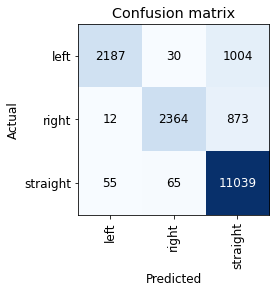

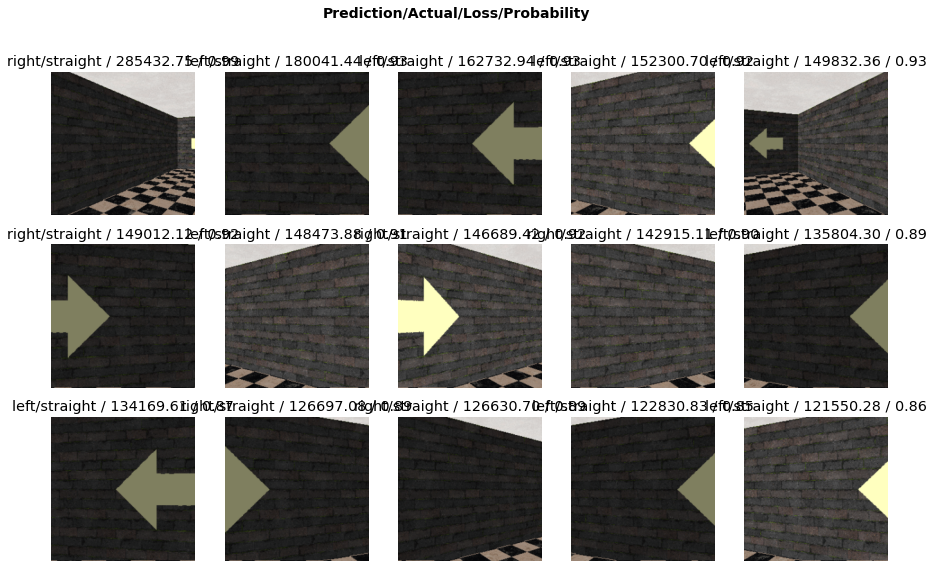

In [17]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(15)

In [18]:
interp.print_classification_report()

              precision    recall  f1-score   support

        left       0.97      0.68      0.80      3221
       right       0.96      0.73      0.83      3249
    straight       0.85      0.99      0.92     11159

    accuracy                           0.88     17629
   macro avg       0.93      0.80      0.85     17629
weighted avg       0.90      0.88      0.88     17629



In [20]:
interp.most_confused()

[('left', 'straight', 1004),
 ('right', 'straight', 873),
 ('straight', 'right', 65),
 ('straight', 'left', 55),
 ('left', 'right', 30),
 ('right', 'left', 12)]

# Without Weights

In [ ]:
learn = cnn_learner(dls, xresnet34, metrics=error_rate)
learn.fine_tune(1, cbs=SaveModelCallback())

# Experimenting Loss Functions

In [8]:
learn = unet_learner(dls, resnet18, metrics=error_rate, loss_func = FocalLossFlat(gamma = 2))
learn.fine_tune(1, cbs=SaveModelCallback())

epoch,train_loss,valid_loss,error_rate,time


ValueError: Expected input batch_size (43008) to match target batch_size (64).

In [1]:
import torch
torch.cuda.empty_cache()

In [4]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |